## Lab 3 Final Part 2: Gaussian Mixture Model and the EM algorithm

In prior classes and Part 1 of this lab, we noted how the Hubble Constant data in recent years displays a tighter distribution than it has for most of the 20th century (with some outliers), yet in detail the data still show an apparent spread and does not appear to be unimodal.

To verify this, one approach is to test whether the set of measurements (or a population) deviates from a simple distribution (e.g. normal).  An example of such a test includes the Kolmogorov-Smirnov test. 

An alternative is to build a model that better describes the data.  Given that the recent H0 data show at least two prominent peaks, we can try to fit the distribution with a Gaussian mixture model.  Here assume that the H0 data can be described by a mixture of normal distributions, each parametrized by their mean, width and amplitude.  To perform this fit, we use an iterative method called **Expectation-Maximization (EM)**.  Unlike MCMC, which is used to sample the full posterior likelihood distribution, EM aims to converge iteratively on the best fit, highest likelihood model.

As described in detail in Chap. 12 of Bayesian Data Analysis (Gelman et al), EM is particularly useful in model fitting where there is missing data or added parameters in the model.  In our case, the missing data are parameters that tell us to which Gaussian component (or cluster) a particular data point belongs. For N data points and K different components to the model, we can imagine generating an NxK matrix that gives the likelihood (or weights) that the Nth data point belongs to Kth cluster. (This matrix is the missing data, and the EM algorithm iteratively refines the expected value of this matrix of weights, in the 'E-step'.)   Additionally in each 'M-step' a new set of model parameters is determined that maximizes the likelihood, progressingly increasing it until it converges on a solution.

The implementation we use here borrows from a version from M Pattacchiola "Implementation of a Gaussian Mixture Model" https://gist.github.com/mpatacchiola/f892afb2d178246af133851e42c8fefc.js, which itself is built on the algorithm as described in the "Mathematics for Machine Learning" (Diesenroth, Faisal and Ong)

### Basic EM steps

Start with an estimate of model parameters (e.g. parameters for each of the Gaussian distributions used in the fit)

* E-step: Estimate the expected value of the 'added parameters', in our case the matrix of mixture weights for each data point.  In the implementation we use, this matrix is called the "responsibility" matrix.
* M-step: Find a new set of parameters that maximize (or more generally increase) the likelihood of the fit

Iterate through EM steps until convergence

### Gaussian mixture model

Experiment below with a Gaussian mixture model with 1, 2, 3 parameters.  We will compare the models both by visually inspecting the fit and 
also using criteria for model selection, AIC and BIC.

Note however, that Gaussian mixture model fitting can be very sensitive to outliers that might throw off the fit, and the
algorithm can be sensitive to the choice of initial parameter!   


#### Comment on fitting a Gaussian Mixture Model to our H0 data:  

You might note that we have prior knowledge that could allow us to determine the weights in advance (we ***don't*** have missing parameters) since we know that some of the H0 data were obtained from CMB data, and others from low-z measurements. etc.  This may be true, but the approach we adopt here is agnostic to that prior knowledge regarding the method used to obtain the data.

### Step 1: Read in Hubble Constant Data and Trim Data (remove outliers, select more recent)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import norm
import scipy.stats as stats

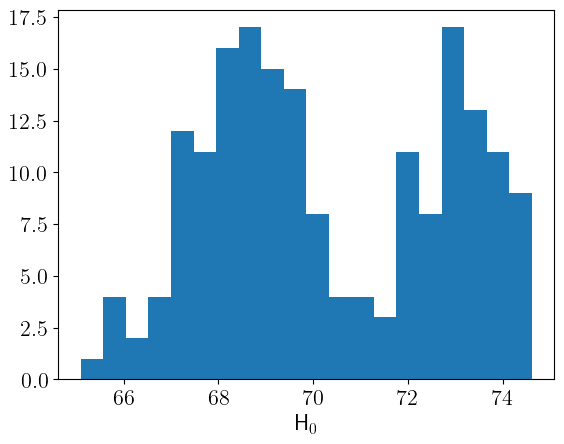

In [ ]:
# Read in the data from a CSV compilation file

# Table of Hubble Constant measurements, over past ~100 years
from astropy.table import Table

# Read the CSV file
table = Table.read("./H0_Data.csv", format="ascii.csv")


year = np.array(table["Year"], dtype="float64")
dither = np.random.uniform(size=len(year))
# Add a small dither offset to year to avoid integer pile-up
year_dith = year + dither


H0 = np.array(table["H0"], dtype="float64")
eH0 = np.array(table["eH0"], dtype="float64")
no_errors = np.where(eH0 < 0.1)[0]
# Replace some with very small error bars with a larger value so as not to interfere
eH0[no_errors] = 5
obsType = np.array(table["ObsType"])


# Trim outliers and store most recent Hubble Constant Data in data array
# Experiment with these (should be fairly narrow, centered around 70 (better +/-10 or +/-5, and may want more recent, 2010)
mincut = 65
maxcut = 75
min_year = 2010

p = np.where((H0 > mincut) & (H0 < maxcut) & (year_dith > min_year))[0]
H0cut = H0[p]
eH0cut = eH0[p]
obsTypecut = obsType[p]
year_dith_cut = year_dith[p]

data = H0[p]

hist, bins, _ = plt.hist(data, bins=20)
plt.xlabel("H$_0$")
plt.show()

In [63]:
#### Gaussian Mixture Model Functions


# Plot the data distributions
def plot_distributions(
    data,
    data_sampled,
    mu,
    sigma,
    K,
    color="green",
    color_sampled="red",
    name="plot.png",
):
    matplotlib.rcParams["text.usetex"] = True
    plt.rcParams.update({"font.size": 16})
    data_sampled = np.clip(data_sampled, np.min(data), np.max(data))
    plt.hist(data, bins=30, color=color, alpha=0.45, density=True)
    plt.hist(
        data_sampled,
        bins=15,
        range=(np.min(data), np.max(data)),
        color=color_sampled,
        alpha=0.45,
        density=True,
    )
    for k in range(K):
        curve = np.linspace(mu[k] - 10 * sigma[k], mu[k] + 10 * sigma[k], 100)
        color = np.random.rand(3)
        plt.plot(
            curve,
            stats.norm.pdf(curve, mu[k], sigma[k]),
            color=color,
            linestyle="--",
            linewidth=3,
            label=r"$\mu_{} = {:.2f}, \sigma_{} = {:.2f}$".format(k, mu[k], k, sigma[k]),
        )
    plt.ylabel(r"$p(x)$")
    plt.xlabel(r"$x$")
    plt.tight_layout()
    #    plt.xlim(20, 120)
    plt.xlim(50, 90)
    plt.savefig(name, dpi=200)
    plt.legend()
    plt.show()


# Show the evolution of the likelihood
def plot_likelihood(nll_list):
    matplotlib.rcParams["text.usetex"] = True
    plt.rcParams.update({"font.size": 16})
    plt.plot(
        np.arange(len(nll_list)), nll_list, color="black", linestyle="--", linewidth=3
    )
    plt.ylabel(r"(negative) log-likelihood")
    plt.xlabel(r"iteration")
    plt.tight_layout()
    plt.xlim(0, len(nll_list))
    plt.savefig("nll.png", dpi=200)
    plt.show()


# Draw samples from the final mixture model
def sampler(pi, mu, sigma, N):
    data = list()
    for n in range(N):
        k = np.random.choice(len(pi), p=pi)
        sample = np.random.normal(loc=mu[k], scale=sigma[k])
        data.append(sample)
    return data

In [64]:
# Basic parameters of the mixture model


N = data.shape[0]  # Number of data points
K = 2  # set number of components components GMM    *** CHANGE THIS TO CHANGE NUMBER OF GAUSSIANS
tot_iterations = 100  # stopping criteria    (Probably no need to edit this)

# Step-1 (Init) - Draw parameters for each gaussian

mu = np.random.uniform(low=mincut, high=maxcut, size=K)  # mean
sigma = np.random.uniform(low=0.5, high=2.0, size=K)  # width
pi = np.ones(K) * (1.0 / K)  # mixing coefficients (amplitudes)

# Matrices of individual weights 'responsibilities' and negative log-likelihoods
r = np.zeros(
    [K, N]
)  # responsibilities, with Mixture model # along first axis, Measurements on 2nd axis
nll_list = list()  # store the neg log-likelihood


for iteration in range(tot_iterations):
    # Step-2 (E-Step)     # Here the expectation for 'responsibility' for each model is simply

    # drawn from a Gaussian pdf, with current mean, sigma, and amplitude
    for k in range(K):
        r[k, :] = pi[k] * norm.pdf(x=data, loc=mu[k], scale=sigma[k])

    # [K,N] -> [N]      # be sure to properly normalize across K
    r = r / np.sum(r, axis=0)

    # Step-3 (M-Step)
    N_k = np.sum(r, axis=1)  # [K,N] -> [K]
    for k in range(K):  # Maximum likelihood extimates
        # update means
        mu[k] = np.sum(r[k, :] * data) / N_k[k]  # Weighted mean for each Gaussian
        # update variances
        numerator = r[k] * (data - mu[k]) ** 2
        sigma[k] = np.sqrt(
            np.sum(numerator) / N_k[k]
        )  # Weighted width for each Gaussian
        # See questions - you might insert code for fixing params here in order to model OUTLIERS
    # update weights
    pi = N_k / N  # New updated amplitude

    likelihood = 0.0
    for k in range(K):
        likelihood += pi[k] * norm.pdf(
            x=data, loc=mu[k], scale=sigma[k]
        )  # calculate new likelihood
    nll_list.append(-np.sum(np.log(likelihood)))
    # Check for invalid negative log-likelihood (NLL)
    # The NLL is invalid if NLL_t-1 < NLL_t
    # Note that this can happen for round-off errors.  DS - added int to avoid chronic round-off errors
    if len(nll_list) >= 2:
        if int(nll_list[-2] * 1e7) < int(nll_list[-1] * 1e7):
            raise Exception("[ERROR] invalid NLL: " + str(nll_list[-2:]))

    print("Iteration: " + str(iteration) + "; NLL: " + str(nll_list[-1]))
    print("Mean " + str(mu) + "\nStd " + str(sigma) + "\nWeights " + str(pi) + "\n")

    # Step-4 (Check)
    if iteration == tot_iterations - 1:
        break  # check iteration

Iteration: 0; NLL: 394.99172275696753
Mean [73.19540474 68.8409729 ]
Std [0.88722208 1.54860947]
Weights [0.33864922 0.66135078]

Iteration: 1; NLL: 392.8817022306889
Mean [73.1566693  68.73238152]
Std [0.79638238 1.46290513]
Weights [0.35784659 0.64215341]

Iteration: 2; NLL: 392.386734480408
Mean [73.14175451 68.68156113]
Std [0.7954769  1.40419185]
Weights [0.36636006 0.63363994]

Iteration: 3; NLL: 392.13803047271085
Mean [73.1234008 68.648891 ]
Std [0.8054429  1.37002651]
Weights [0.37248926 0.62751074]

Iteration: 4; NLL: 392.00486451828084
Mean [73.10817461 68.62628983]
Std [0.81530753 1.3473925 ]
Weights [0.3769191 0.6230809]

Iteration: 5; NLL: 391.93687896002314
Mean [73.09681053 68.610619  ]
Std [0.82317937 1.33192933]
Weights [0.38005039 0.61994961]

Iteration: 6; NLL: 391.9035711026693
Mean [73.0886635  68.59986422]
Std [0.82904854 1.32140267]
Weights [0.38222551 0.61777449]

Iteration: 7; NLL: 391.8877045927893
Mean [73.08294895 68.59254646]
Std [0.83327686 1.31428444]
We

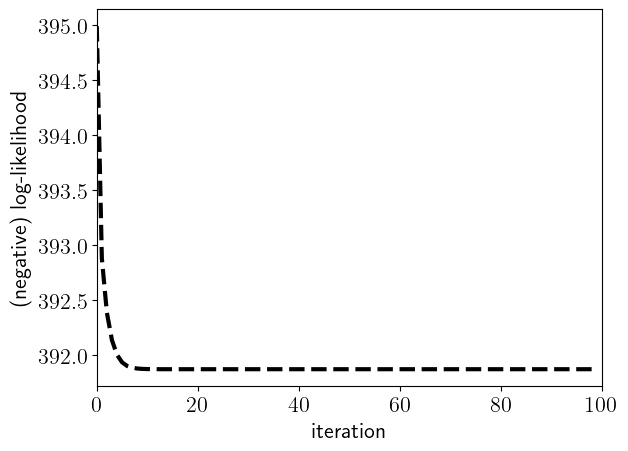

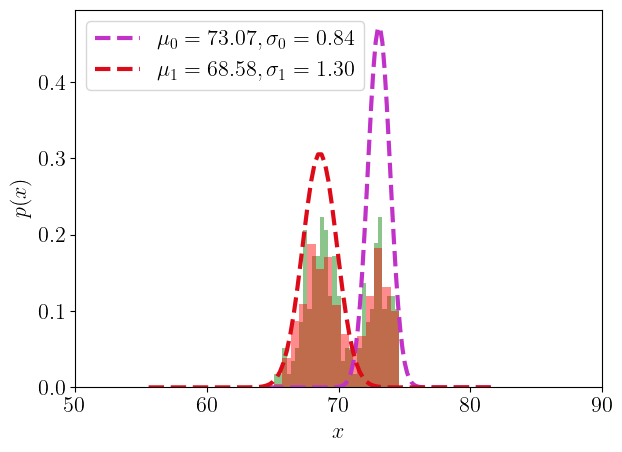

N:  184 K: 2 NLL:391.8739706445649
AIC:793.7479412891298
BIC:404.9113100385874


In [65]:
# Make plots
plot_likelihood(nll_list)

# SAMPLE from the GMM, 1000 data points, for comparison with the measured data
data_gmm = sampler(pi, mu, sigma, N=1000)
plot_distributions(
    data,
    data_gmm,
    mu,
    sigma,
    K,
    color="green",
    color_sampled="red",
    name="plot_sampler.png",
)
# Calculate AIC and BIC assuming k gaussians with 3 parameters each
# number of free parameters for k gaussians with 3 free parameters p=3k−1,
BIC = nll_list[-1] + (3 * K - 1) / 2 * np.log(N)
AIC = 2 * (3 * K - 1) + 2 * nll_list[-1]
# Remember NLL is negative log-likelihood!
print("N:  " + str(N) + " K: " + str(K) + " NLL:" + str(nll_list[-1]))
print("AIC:" + str(AIC))
print("BIC:" + str(BIC))

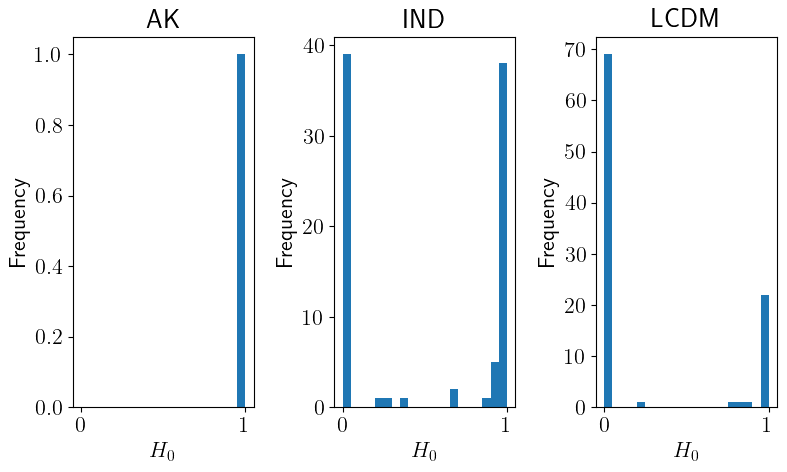

In [66]:
# Example histograms to show how obsType classifications compare to the GMM classification
obsTypes = np.unique(obsTypecut)
num_obsTypes = len(obsTypes)

fig, axes = plt.subplots(nrows=(num_obsTypes // 5) + 1, ncols=6, figsize=(16, 5))
axes = axes.flatten()

for i, otype in enumerate(obsTypes):
    p = np.where(otype == obsTypecut)
    axes[i].hist(r[0, p[0]], bins=20, range=(0, 1))
    axes[i].set_xlabel(r"$H_0$")
    axes[i].set_title(str(otype))
    axes[i].set_ylabel("Frequency")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Questions on the Gaussian Mixture Model

* First, with k=2, experiment with selecting a set of outlier cuts (min, max) and starting year to get a clean double-peaked data set that should give you a sensible fit.


* Once you have a good set of fits with k=2, perform runs with with k = 1, 2 and 3 Gaussian functions in your 'mixture model'.


Iteration: 0; NLL: 427.43598868277473
Mean [70.31559783]
Std [2.46966656]
Weights [1.]

Iteration: 1; NLL: 427.43598868277473
Mean [70.31559783]
Std [2.46966656]
Weights [1.]

Iteration: 2; NLL: 427.43598868277473
Mean [70.31559783]
Std [2.46966656]
Weights [1.]

Iteration: 3; NLL: 427.43598868277473
Mean [70.31559783]
Std [2.46966656]
Weights [1.]

Iteration: 4; NLL: 427.43598868277473
Mean [70.31559783]
Std [2.46966656]
Weights [1.]

Iteration: 5; NLL: 427.43598868277473
Mean [70.31559783]
Std [2.46966656]
Weights [1.]

Iteration: 6; NLL: 427.43598868277473
Mean [70.31559783]
Std [2.46966656]
Weights [1.]

Iteration: 7; NLL: 427.43598868277473
Mean [70.31559783]
Std [2.46966656]
Weights [1.]

Iteration: 8; NLL: 427.43598868277473
Mean [70.31559783]
Std [2.46966656]
Weights [1.]

Iteration: 9; NLL: 427.43598868277473
Mean [70.31559783]
Std [2.46966656]
Weights [1.]

Iteration: 10; NLL: 427.43598868277473
Mean [70.31559783]
Std [2.46966656]
Weights [1.]

Iteration: 11; NLL: 427.4359886

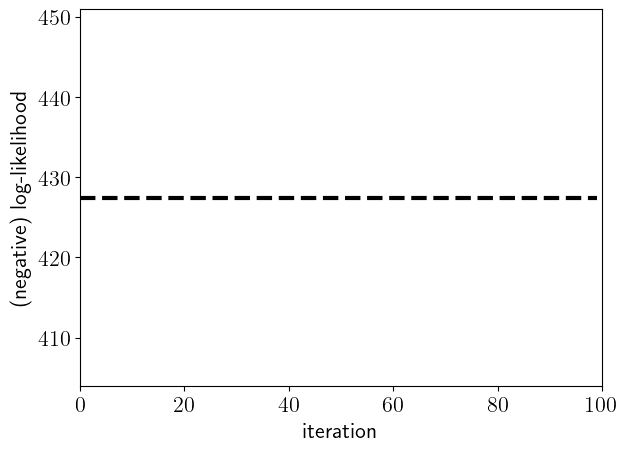

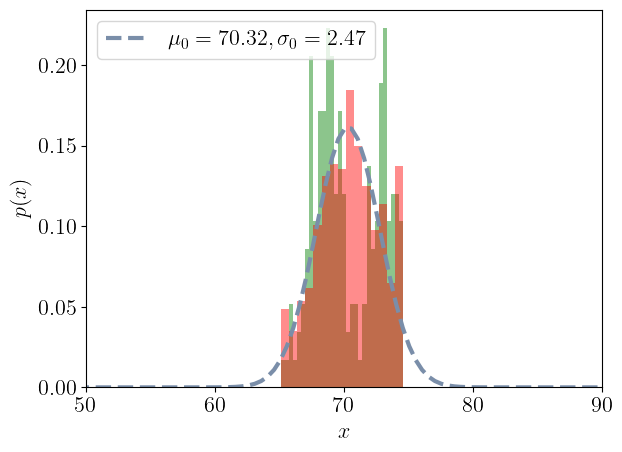

N:  184 K: 1 NLL:427.43598868277473
AIC:858.8719773655495
BIC:432.65092444038373


In [67]:
# Basic parameters of the mixture model

N = data.shape[0]  # Number of data points
K = 1  # set number of components components GMM    *** CHANGE THIS TO CHANGE NUMBER OF GAUSSIANS
tot_iterations = 100  # stopping criteria    (Probably no need to edit this)

# Step-1 (Init) - Draw parameters for each gaussian

mu = np.random.uniform(low=mincut, high=maxcut, size=K)  # mean
sigma = np.random.uniform(low=0.5, high=2.0, size=K)  # width
pi = np.ones(K) * (1.0 / K)  # mixing coefficients (amplitudes)

# Matrices of individual weights 'responsibilities' and negative log-likelihoods
r = np.zeros(
    [K, N]
)  # responsibilities, with Mixture model # along first axis, Measurements on 2nd axis
nll_list = list()  # store the neg log-likelihood


for iteration in range(tot_iterations):
    # Step-2 (E-Step)     # Here the expectation for 'responsibility' for each model is simply
    # drawn from a Gaussian pdf, with current mean, sigma, and amplitude
    for k in range(K):
        r[k, :] = pi[k] * norm.pdf(x=data, loc=mu[k], scale=sigma[k])

    # [K,N] -> [N]      # be sure to properly normalize across K
    r = r / np.sum(r, axis=0)

    # Step-3 (M-Step)
    N_k = np.sum(r, axis=1)  # [K,N] -> [K]
    for k in range(K):  # Maximum likelihood extimates
        # update means
        mu[k] = np.sum(r[k, :] * data) / N_k[k]  # Weighted mean for each Gaussian
        # update variances
        numerator = r[k] * (data - mu[k]) ** 2
        sigma[k] = np.sqrt(
            np.sum(numerator) / N_k[k]
        )  # Weighted width for each Gaussian
        # See questions - you might insert code for fixing params here in order to model OUTLIERS
    # update weights
    pi = N_k / N  # New updated amplitude

    likelihood = 0.0
    for k in range(K):
        likelihood += pi[k] * norm.pdf(
            x=data, loc=mu[k], scale=sigma[k]
        )  # calculate new likelihood
    nll_list.append(-np.sum(np.log(likelihood)))
    # Check for invalid negative log-likelihood (NLL)
    # The NLL is invalid if NLL_t-1 < NLL_t
    # Note that this can happen for round-off errors.  DS - added int to avoid chronic round-off errors
    if len(nll_list) >= 2:
        if int(nll_list[-2] * 1e7) < int(nll_list[-1] * 1e7):
            raise Exception("[ERROR] invalid NLL: " + str(nll_list[-2:]))

    print("Iteration: " + str(iteration) + "; NLL: " + str(nll_list[-1]))
    print("Mean " + str(mu) + "\nStd " + str(sigma) + "\nWeights " + str(pi) + "\n")

    # Step-4 (Check)
    if iteration == tot_iterations - 1:
        break  # check iteration

# Make plots
plot_likelihood(nll_list)

# SAMPLE from the GMM, 1000 data points, for comparison with the measured data
data_gmm = sampler(pi, mu, sigma, N=1000)
plot_distributions(
    data,
    data_gmm,
    mu,
    sigma,
    K,
    color="green",
    color_sampled="red",
    name="plot_sampler.png",
)
# Calculate AIC and BIC assuming k gaussians with 3 parameters each
# number of free parameters for k gaussians with 3 free parameters p=3k−1,
BIC = nll_list[-1] + (3 * K - 1) / 2 * np.log(N)
AIC = 2 * (3 * K - 1) + 2 * nll_list[-1]
# Remember NLL is negative log-likelihood!
print("N:  " + str(N) + " K: " + str(K) + " NLL:" + str(nll_list[-1]))
print("AIC:" + str(AIC))
print("BIC:" + str(BIC))

Iteration: 0; NLL: 412.3776142243518
Mean [71.46053185 66.65054713 68.42629955]
Std [2.23027785 0.90202053 0.76466575]
Weights [0.65457261 0.05452735 0.29090004]

Iteration: 1; NLL: 411.38495901718045
Mean [71.57010592 66.64103987 68.39227845]
Std [2.14427847 0.8745803  0.77384884]
Weights [0.63865182 0.06064618 0.300702  ]

Iteration: 2; NLL: 410.43492504101823
Mean [71.68171982 66.6220425  68.37923889]
Std [2.05864756 0.86813119 0.77912739]
Weights [0.62115879 0.06544864 0.31339258]

Iteration: 3; NLL: 409.43854995750576
Mean [71.79505627 66.60844199 68.37949297]
Std [1.97338674 0.86570373 0.78430153]
Weights [0.60265264 0.06905131 0.32829605]

Iteration: 4; NLL: 408.3523529646855
Mean [71.91003949 66.60155527 68.38933732]
Std [1.88741545 0.86370346 0.79096893]
Weights [0.58351229 0.07166001 0.3448277 ]

Iteration: 5; NLL: 407.1415831370381
Mean [72.02669148 66.59945869 68.40683846]
Std [1.79935031 0.86202459 0.79973883]
Weights [0.56398839 0.07347416 0.36253746]

Iteration: 6; NLL: 

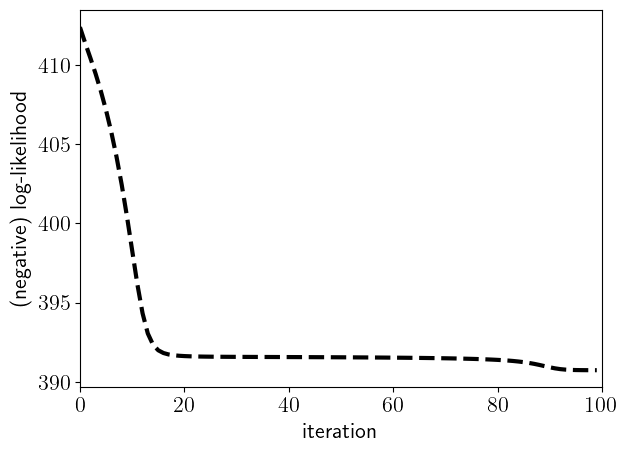

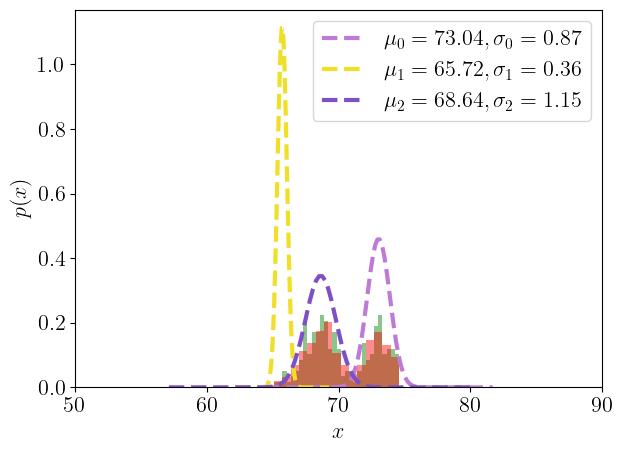

N:  184 K: 3 NLL:390.74892705419927
AIC:797.4978541083985
BIC:411.6086700846352


In [68]:
# Basic parameters of the mixture model

N = data.shape[0]  # Number of data points
K = 3  # set number of components components GMM    *** CHANGE THIS TO CHANGE NUMBER OF GAUSSIANS
tot_iterations = 100  # stopping criteria    (Probably no need to edit this)

# Step-1 (Init) - Draw parameters for each gaussian

mu = np.random.uniform(low=mincut, high=maxcut, size=K)  # mean
sigma = np.random.uniform(low=0.5, high=2.0, size=K)  # width
pi = np.ones(K) * (1.0 / K)  # mixing coefficients (amplitudes)

# Matrices of individual weights 'responsibilities' and negative log-likelihoods
r = np.zeros(
    [K, N]
)  # responsibilities, with Mixture model # along first axis, Measurements on 2nd axis
nll_list = list()  # store the neg log-likelihood


for iteration in range(tot_iterations):
    # Step-2 (E-Step)     # Here the expectation for 'responsibility' for each model is simply
    # drawn from a Gaussian pdf, with current mean, sigma, and amplitude
    for k in range(K):
        r[k, :] = pi[k] * norm.pdf(x=data, loc=mu[k], scale=sigma[k])

    # [K,N] -> [N]      # be sure to properly normalize across K
    r = r / np.sum(r, axis=0)

    # Step-3 (M-Step)
    N_k = np.sum(r, axis=1)  # [K,N] -> [K]
    for k in range(K):  # Maximum likelihood extimates
        # update means
        mu[k] = np.sum(r[k, :] * data) / N_k[k]  # Weighted mean for each Gaussian
        # update variances
        numerator = r[k] * (data - mu[k]) ** 2
        sigma[k] = np.sqrt(
            np.sum(numerator) / N_k[k]
        )  # Weighted width for each Gaussian
        # See questions - you might insert code for fixing params here in order to model OUTLIERS
    # update weights
    pi = N_k / N  # New updated amplitude

    likelihood = 0.0
    for k in range(K):
        likelihood += pi[k] * norm.pdf(
            x=data, loc=mu[k], scale=sigma[k]
        )  # calculate new likelihood
    nll_list.append(-np.sum(np.log(likelihood)))
    # Check for invalid negative log-likelihood (NLL)
    # The NLL is invalid if NLL_t-1 < NLL_t
    # Note that this can happen for round-off errors.  DS - added int to avoid chronic round-off errors
    if len(nll_list) >= 2:
        if int(nll_list[-2] * 1e7) < int(nll_list[-1] * 1e7):
            raise Exception("[ERROR] invalid NLL: " + str(nll_list[-2:]))

    print("Iteration: " + str(iteration) + "; NLL: " + str(nll_list[-1]))
    print("Mean " + str(mu) + "\nStd " + str(sigma) + "\nWeights " + str(pi) + "\n")

    # Step-4 (Check)
    if iteration == tot_iterations - 1:
        break  # check iteration

# Make plots
plot_likelihood(nll_list)

# SAMPLE from the GMM, 1000 data points, for comparison with the measured data
data_gmm = sampler(pi, mu, sigma, N=1000)
plot_distributions(
    data,
    data_gmm,
    mu,
    sigma,
    K,
    color="green",
    color_sampled="red",
    name="plot_sampler.png",
)
# Calculate AIC and BIC assuming k gaussians with 3 parameters each
# number of free parameters for k gaussians with 3 free parameters p=3k−1,
BIC = nll_list[-1] + (3 * K - 1) / 2 * np.log(N)
AIC = 2 * (3 * K - 1) + 2 * nll_list[-1]
# Remember NLL is negative log-likelihood!
print("N:  " + str(N) + " K: " + str(K) + " NLL:" + str(nll_list[-1]))
print("AIC:" + str(AIC))
print("BIC:" + str(BIC))

* Visually, which appears to give you the best model fit?  Do the final parameters for the Gaussian(s) seem reasonable?

> The 2-gausian, bimodal distribution appears to give the best model fit.

* For the output of the k=1, 2, 3 models, calculate the Bayesian Information Criterion (BIC) and Akaike Information Criterion as discussed in David K's lecture.  Use the log likelihood (= -NLL), number of measurements and number of parameters.  Remember that each Gaussian has 3 parameters!


* Does the BIC or AIC provide results that are consistent with what you believe to be the best model?  (Might these useful statistics for model selection?)


* For the k=2 model, how does the result of the mixture model compare with the classifications (obsType) in the H0 catalog?  Does the GMM appear to divide up the sample by observation type?  Are there notable differences?


### Application to H0 outlier selection

* There are similarities with what we were doing in the previous part of the lab (following Press 1997).  For example,
we could require one of the Gaussian components to have a fixed center and width (but not amplitude) in order to represent the 'bad data'. Try this with two components, where you fix the first component with the below code. How well does this work?  Are you able to use another Gaussian to represent the problematic tail of the distribution?    

if k==0: sigma[k]=10; mu[k]=70
    
Insert in the code location identified above (Look for word OUTLIER)

* In terms of outliers, how might this method identify similar outliers as the previous method?  Which outliers might not show up using this method?
